In [34]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# 设置数据读取器，API自动读取MNIST数据训练集
paddle.vision.set_image_backend('cv2')
train_dataset = paddle.vision.datasets.MNIST(mode='train')
test_dataset = paddle.vision.datasets.MNIST(mode='test')
# 加载训练集 batch_size 设为 16
train_loader = paddle.io.DataLoader(train_dataset, 
                                    batch_size=16, 
                                    shuffle=True)
test_loader = paddle.io.DataLoader(test_dataset, 
                                    batch_size=16, 
                                    shuffle=True)

In [72]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[0, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img / 255
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

def evaluation(model, datasets):
    model.eval()

    acc_set = list()
    for batch_id, data in enumerate(datasets()):
        images, labels = data
        images = norm_img(images).astype('float32')
        labels = labels.astype('int64')
        pred = model(images)   # 获取预测值
        acc = paddle.metric.accuracy(input=pred, label=labels)
        acc_set.append(acc.numpy())
    
    # #计算多个batch的准确率
    acc_val_mean = np.array(acc_set).mean()
    return acc_val_mean

#仅修改计算损失的函数，从均方误差（常用于回归问题）到交叉熵误差（常用于分类问题）
def train(model, EPOCH_NUM=10, learning_rate=0.01):
    train_loss_list = []
    val_acc_list = []

    model.train()

    opt = paddle.optimizer.SGD(learning_rate=learning_rate, parameters=model.parameters())
    EPOCH_NUM = EPOCH_NUM
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据
            images, labels = data
            images = norm_img(images).astype('float32')
            labels = labels.astype('int64')
            #前向计算的过程
            predicts = model(images)
            
            #计算损失，使用交叉熵损失函数，取一个批次样本损失的平均值
            loss = F.cross_entropy(predicts, labels)
            avg_loss = paddle.mean(loss)

            train_loss_list.append(avg_loss.numpy())
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
        acc_val_mean = evaluation(model, test_loader)

        val_acc_list.append(acc_val_mean)

        print('val acc: {}'.format(acc_val_mean))   
    # 保存模型参数
    # paddle.save(model.state_dict(), 'mnist.pdparams')
    return model, train_loss_list, val_acc_list

In [38]:
import paddle.nn.functional as F
from paddle.nn import Linear

# 定义多层全连接神经网络
class FCNet(paddle.nn.Layer):
    def __init__(self):
        super(FCNet, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
        self.fc1 = Linear(in_features=784, out_features=10)
        self.fc2 = Linear(in_features=10, out_features=10)
        # 定义一层全连接输出层，输出维度是10
        self.fc3 = Linear(in_features=10, out_features=10)
    
    # 定义网络的前向计算，隐含层激活函数为sigmoid，输出层不使用激活函数
    def forward(self, inputs):
        # inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = F.sigmoid(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = F.sigmoid(outputs2)
        outputs_final = self.fc3(outputs2)
        return outputs_final

In [65]:
import paddle.nn.functional as F
from paddle.nn import Linear
from PaddleGaussionKAN.KANActivation import KANActivation

# 定义多层全连接神经网络
class FCNetKANAct(paddle.nn.Layer):
    def __init__(self):
        super(FCNetKANAct, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
        self.fc1 = Linear(in_features=784, out_features=10)
        self.kan1 = KANActivation(10)
        self.fc2 = Linear(in_features=10, out_features=10)
        self.kan2 = KANActivation(10)
        self.fc3 = Linear(in_features=10, out_features=10)
    
    # 定义网络的前向计算，隐含层激活函数为KANact，输出层不使用激活函数
    def forward(self, inputs):
        # inputs = paddle.reshape(inputs, [inputs.shape[0], 784])
        outputs1 = self.fc1(inputs)
        outputs1 = self.kan1(outputs1)
        outputs2 = self.fc2(outputs1)
        outputs2 = self.kan2(outputs2)
        outputs_final = self.fc3(outputs2)
        return outputs_final

In [43]:
from PaddleGaussionKAN.KANLayer import KANLayer

# 定义多层KAN网络
class KANNet(paddle.nn.Layer):
    def __init__(self):
        super(KANNet, self).__init__()
        # 定义两层全连接隐含层，输出维度是10，当前设定隐含节点数为10，可根据任务调整
        self.kan1 = KANLayer(in_channels=784, out_channels=10, g=10)
        self.kan2 = KANLayer(in_channels=10, out_channels=10, g=10)
    
    def forward(self, inputs):
        outputs1 = self.kan1(inputs)
        outputs_final = self.kan2(outputs1)
        return outputs_final

In [ ]:
#创建模型    
model_fc = FCNet()
# model_kan = KANNet() # 不收敛
model_fckan = FCNetKANAct()
#启动训练过程
model_fc, train_loss_list_fc, val_acc_list_fc = train(model_fc)
# model_kan, train_loss_list_kan, val_acc_list_kan = train(model_kan)
model_kanact, train_loss_list_kanact, val_acc_list_kanact = train(model_fckan)

In [73]:
model_fc = FCNet()
model_fc, train_loss_list_fc, val_acc_list_fc = train(model_fc)

epoch: 0, batch: 0, loss is: 2.3865885734558105
epoch: 0, batch: 200, loss is: 2.2510509490966797
epoch: 0, batch: 400, loss is: 2.2933053970336914
epoch: 0, batch: 600, loss is: 2.291668653488159
epoch: 0, batch: 800, loss is: 2.271818161010742
epoch: 0, batch: 1000, loss is: 2.3061559200286865
epoch: 0, batch: 1200, loss is: 2.272063732147217
epoch: 0, batch: 1400, loss is: 2.263731002807617
epoch: 0, batch: 1600, loss is: 2.280304431915283
epoch: 0, batch: 1800, loss is: 2.257697343826294
epoch: 0, batch: 2000, loss is: 2.240994930267334
epoch: 0, batch: 2200, loss is: 2.2340080738067627
epoch: 0, batch: 2400, loss is: 2.214352607727051
epoch: 0, batch: 2600, loss is: 2.2551941871643066
epoch: 0, batch: 2800, loss is: 2.2590997219085693
epoch: 0, batch: 3000, loss is: 2.206367254257202
epoch: 0, batch: 3200, loss is: 2.1845200061798096
epoch: 0, batch: 3400, loss is: 2.1761703491210938
epoch: 0, batch: 3600, loss is: 2.1380162239074707
val acc: 0.4447000026702881
epoch: 1, batch: 0,

In [74]:
#创建模型    
model_fckan = FCNetKANAct()
#启动训练过程
model_kanact, train_loss_list_kanact, val_acc_list_kanact = train(model_fckan)

epoch: 0, batch: 0, loss is: 2.812007427215576
epoch: 0, batch: 200, loss is: 1.8676427602767944
epoch: 0, batch: 400, loss is: 1.484445333480835
epoch: 0, batch: 600, loss is: 1.036101222038269
epoch: 0, batch: 800, loss is: 1.1081664562225342
epoch: 0, batch: 1000, loss is: 0.792035698890686
epoch: 0, batch: 1200, loss is: 0.6874635815620422
epoch: 0, batch: 1400, loss is: 0.4628177881240845
epoch: 0, batch: 1600, loss is: 0.3506278991699219
epoch: 0, batch: 1800, loss is: 0.5151956677436829
epoch: 0, batch: 2000, loss is: 0.5816914439201355
epoch: 0, batch: 2200, loss is: 0.4629705548286438
epoch: 0, batch: 2400, loss is: 0.12014701217412949
epoch: 0, batch: 2600, loss is: 0.20532609522342682
epoch: 0, batch: 2800, loss is: 0.3094605803489685
epoch: 0, batch: 3000, loss is: 0.3424238860607147
epoch: 0, batch: 3200, loss is: 0.812615156173706
epoch: 0, batch: 3400, loss is: 0.4039924144744873
epoch: 0, batch: 3600, loss is: 0.0720912367105484
val acc: 0.8930000066757202
epoch: 1, bat

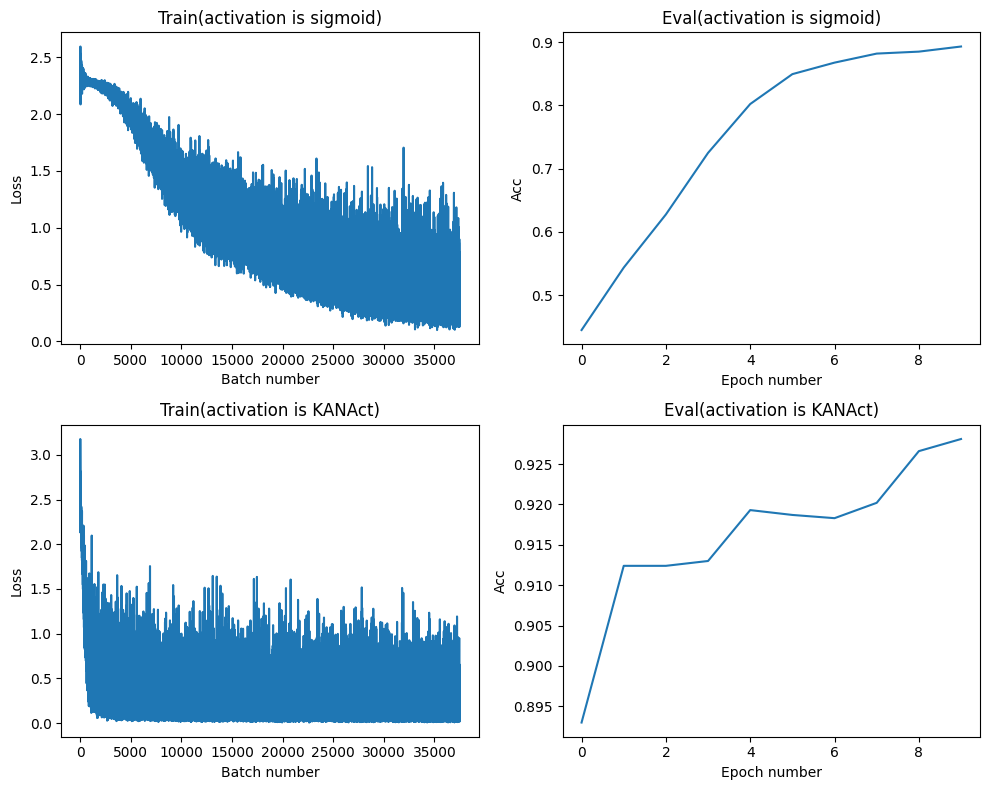

In [75]:
import matplotlib.pyplot as plt  
  
# 假设这四个列表已经被定义并包含了相应的数据  
train_loss_net1 = train_loss_list_fc  # 网络1的训练loss数据  
val_acc_net1 = val_acc_list_fc     # 网络1的验证集精度数据  
train_loss_net2 = train_loss_list_kanact  # 网络2的训练loss数据  
val_acc_net2 = val_acc_list_kanact     # 网络2的验证集精度数据  
  
# 创建一个图形和四个子图  
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  
  
# 绘制网络1的训练loss变化  
axs[0, 0].plot(train_loss_net1)  
axs[0, 0].set_title('Train(activation is sigmoid)')  
axs[0, 0].set_xlabel('Batch number')  
axs[0, 0].set_ylabel('Loss')  
  
# 绘制网络1的验证集精度变化  
axs[0, 1].plot(val_acc_net1)  
axs[0, 1].set_title('Eval(activation is sigmoid)')  
axs[0, 1].set_xlabel('Epoch number')  
axs[0, 1].set_ylabel('Acc')  
  
# 绘制网络2的训练loss变化  
axs[1, 0].plot(train_loss_net2)  
axs[1, 0].set_title('Train(activation is KANAct)')  
axs[1, 0].set_xlabel('Batch number')  
axs[1, 0].set_ylabel('Loss')  
  
# 绘制网络2的验证集精度变化  
axs[1, 1].plot(val_acc_net2)  
axs[1, 1].set_title('Eval(activation is KANAct)')  
axs[1, 1].set_xlabel('Epoch number')  
axs[1, 1].set_ylabel('Acc')  
  
# 调整子图之间的距离  
plt.tight_layout()  

plt.savefig('networks_performance.jpg')  
  
# 显示图形  
plt.show()

In [51]:
model_kan = KANNet()

In [54]:
model_kan.kan1.a

Parameter containing:
Tensor(shape=[784, 10, 10], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[ 0.01320365, -0.00277781, -0.02698902, ...,  0.01932328,
           0.01387573,  0.00879871],
         [ 0.00657906, -0.01127188,  0.02424551, ..., -0.02298590,
           0.00504922,  0.00947799],
         [ 0.01640570, -0.01963619,  0.00541366, ...,  0.01209505,
          -0.00409864,  0.00074745],
         ...,
         [ 0.01715168, -0.02652662, -0.01564564, ...,  0.00979721,
          -0.00663382,  0.00966013],
         [-0.02512837,  0.01656125, -0.01587788, ..., -0.00088550,
          -0.02507377,  0.01253234],
         [-0.02005831,  0.00464665,  0.01377756, ..., -0.02690904,
          -0.01045764,  0.01529879]],

        [[ 0.01210591, -0.00921405,  0.00899876, ...,  0.00341694,
          -0.01324241,  0.00913776],
         [ 0.00999484, -0.00165515,  0.00483359, ..., -0.00223100,
           0.01035389, -0.01603820],
         [ 0.00770418, -0.01186569, -0.0010219

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 